# Engenharia do Conhecimento 2023/2024
# Project *by Gabriel Henriques 58182 and Guilherme Sousa 58170*

### Dataset: A version of the "thyroid0387"


# RUN BEFORE TESTING!

In [4]:
import numpy as np; import pandas as pd;from sklearn.compose import ColumnTransformer;from sklearn.impute import SimpleImputer;
from sklearn.pipeline import Pipeline; from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder;from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt;from sklearn.model_selection import cross_val_score;from sklearn.model_selection import GridSearchCV

# DATA CLEANING
categorical_features = ['sex:', 'on thyroxine:', 'query on thyroxine:', 'on antithyroid medication:',
                        'sick:', 'pregnant:', 'thyroid surgery:', 'I131 treatment:', 'query hypothyroid:',
                        'query hyperthyroid:', 'lithium:', 'goitre:', 'tumor:', 'hypopituitary:',
                        'psych:', 'TSH measured:', 'T3 measured:', 'TT4 measured:', 'T4U measured:',
                        'FTI measured:', 'TBG measured:', 'referral source:', 'diagnoses']
continuous_features = ['age:', 'TSH:', 'T3:', 'TT4:', 'T4U:', 'FTI:', 'TBG:']

def diagnoses_to_class(diganoses):
    new_diagnoses = []
    for diagnose in diganoses:
        if diagnose in ["A","B","C","D"]: new_diagnoses.append("hyperthyroid conditions")
        elif diagnose in ["E","F","G","H"]: new_diagnoses.append("hypothyroid conditions")
        elif diagnose in ["I","J"]: new_diagnoses.append("binding protein") 
        elif diagnose == "K": new_diagnoses.append("general health")
        elif diagnose in ["L","M", "N"]: new_diagnoses.append("replacement therapy")
        elif diagnose == "R": new_diagnoses.append("discordant results")
        elif diagnose == "-": new_diagnoses.append("healthy")
        else: new_diagnoses.append("other")
    return new_diagnoses

def data_cleaning_diag(df_data, y_raw = None):
  target = "diagnoses"
  df_data = df_data.replace('?', np.nan)
  if y_raw is None:
    y_raw = df_data[target].values
    df_data = df_data.drop([target], axis=1)
  X = df_data.drop(["[record identification]"], axis=1)
  y = diagnoses_to_class(y_raw)
  return X, y

def data_cleaning_age(df_data, y = None):
  target = "age:"
  df_data = df_data.replace('?', np.nan)
  if y is None:
    y = df_data[target]
    df_data = df_data.drop([target], axis=1)
  X = df_data.drop(["[record identification]"], axis=1)
  X["diagnoses"] = diagnoses_to_class(X["diagnoses"])
  return X, y
   
def data_cleaning_sex(df_data, y = None):
  target = "sex:"
  df_data = df_data.replace('?', np.nan)
  if y is None:
    df_data = df_data.dropna(subset=['sex:'])
    y = df_data[target]
    df_data = df_data.drop([target], axis=1)
  X = df_data.drop(["[record identification]"], axis=1)
  X["diagnoses"] = diagnoses_to_class(X["diagnoses"])
  return X, y

# DATA PREPROCESSING
def preprocess(cat_features, con_features, X_train, X_test = None):
  categorical_pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy="constant", fill_value="missing")),
      ('encoder', OrdinalEncoder())
  ])
  continuous_pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy="constant", fill_value=-1)),
      ('scaler', MinMaxScaler())
  ])
  preprocessor = ColumnTransformer([
      ('categorical', categorical_pipeline, cat_features),
      ('continuous', continuous_pipeline, con_features)
  ])

  X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())
  if X_test is not None:
    X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())
    return X_train_preprocessed, X_test_preprocessed
  return X_train_preprocessed

# FEATURE SELECTION
def feature_selection(X_train_preprocessed, y_train, max_features, model):
  n_features = range(1, max_features)
  scores = {}
  for i in n_features:
      sfs = SequentialFeatureSelector(model, n_features_to_select=i,n_jobs=-1).set_output(transform="pandas")
      X_train_selected = pd.DataFrame(sfs.fit_transform(X_train_preprocessed, y_train), columns = sfs.get_feature_names_out())
      score = cross_val_score(model, X_train_selected, y_train, cv=5).mean()
      scores.update({i: (score, X_train_selected)})

  plt.figure(figsize=(5, 3))
  plt.plot(scores.keys(), [score for score, _ in scores.values()])
  plt.xlabel("Number of features")
  plt.ylabel("Score")
  plt.title("Number of features vs. Score")
  plt.show()
  return scores

# MODELS SELECTION
def models_selection(X_train_selected, y_train, models):
  scores = {}
  for model in models:
    model.fit(X_train_selected, y_train)
    score = cross_val_score(model, X_train_selected, y_train, cv=5).mean()
    print(f"Cross validation score for model {model} is {score}")
    scores.update({model: score})
  return scores

def plot_importances(importances, X):
    plt.figure(figsize=(5, 3))
    plt.bar(X.columns, importances)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"Feature importances")
    plt.show()

# HYPERPARAMETER TUNING
def fine_tune_model(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best cross-validation score:", grid_search.best_score_)
    print("Best estimator:", grid_search.best_estimator_)
    print()
    return grid_search.best_estimator_

## Diagnoses Prediction 

### Data Cleaning and Preprocess

In [5]:
import pandas as pd
df_data = pd.read_csv("data/proj-data.csv")
X_train, y_train = data_cleaning_diag(df_data)
cat_features = categorical_features.copy()
cat_features.remove('diagnoses')
X_train_preprocessed = preprocess(cat_features, continuous_features, X_train)

### Feature Selection

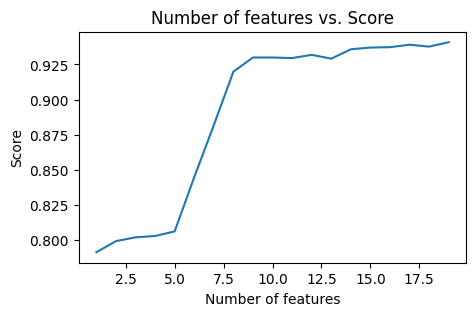

In [6]:
from sklearn.tree import DecisionTreeClassifier
feature_scores = feature_selection(X_train_preprocessed, y_train, 20, DecisionTreeClassifier())

In [7]:
X_train_selected = feature_scores[9][1]
print(f"Selected features: {X_train_selected.columns}")

Selected features: Index(['categorical__on thyroxine:', 'categorical__pregnant:',
       'categorical__thyroid surgery:', 'categorical__referral source:',
       'continuous__TSH:', 'continuous__T3:', 'continuous__TT4:',
       'continuous__FTI:', 'continuous__TBG:'],
      dtype='object')


### Model Selection

In [8]:
from sklearn.tree import DecisionTreeClassifier;from sklearn.naive_bayes import GaussianNB;from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC;from sklearn.ensemble import RandomForestClassifier

classification_models = [DecisionTreeClassifier(),GaussianNB(),KNeighborsClassifier(),SVC(),RandomForestClassifier()]
model_scores = models_selection(X_train_selected, y_train, classification_models)

Cross validation score for model DecisionTreeClassifier() is 0.9291329317649506
Cross validation score for model GaussianNB() is 0.14118397664142474
Cross validation score for model KNeighborsClassifier() is 0.8612661105631801
Cross validation score for model SVC() is 0.7451618625194794
Cross validation score for model RandomForestClassifier() is 0.9433064197076835


### Fine-tuning

In [9]:
decision_tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 9],
    'min_samples_leaf': [1, 2, 5, 9],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.01]
}
dt = fine_tune_model(X_train_selected, y_train, DecisionTreeClassifier(), decision_tree_params)

random_forest_params = {
    'n_estimators': [50,100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 9],
    'min_samples_leaf': [1, 2, 5, 9],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.01]
}
rf = fine_tune_model(X_train_selected, y_train, RandomForestClassifier(), random_forest_params)

Best cross-validation score: 0.9363548475173156
Best estimator: DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5)

Best cross-validation score: 0.942761181970657
Best estimator: RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=5)



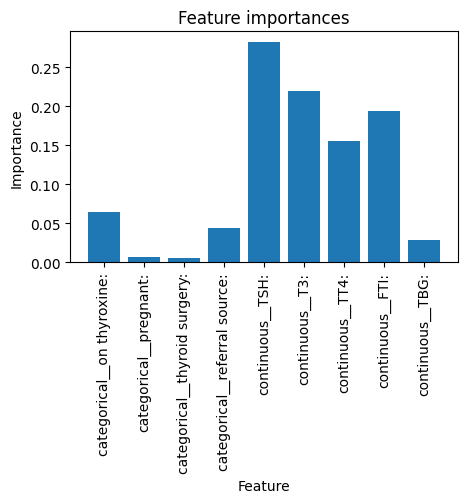

In [10]:
plot_importances(rf.feature_importances_,X_train_selected)

## Sex Prediction

### Preprocess

In [11]:
import pandas as pd

df_data = pd.read_csv("data/proj-data.csv")

X_train, y_train = data_cleaning_sex(df_data)

cat_features = categorical_features.copy()
cat_features.remove('sex:')

X_train_preprocessed = preprocess(cat_features, continuous_features, X_train)

### Feature Selection

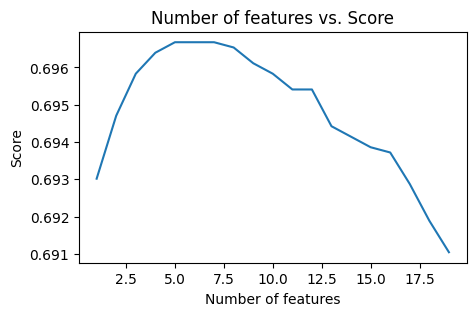

In [12]:
from sklearn.tree import DecisionTreeClassifier
feature_scores = feature_selection(X_train_preprocessed, y_train, 20, DecisionTreeClassifier())

In [13]:
X_train_selected = feature_scores[6][1]
print(f"Selected features: {X_train_selected.columns}")

Selected features: Index(['categorical__on thyroxine:', 'categorical__query on thyroxine:',
       'categorical__pregnant:', 'categorical__thyroid surgery:',
       'categorical__referral source:', 'categorical__diagnoses'],
      dtype='object')


### Model Selection

In [14]:
from sklearn.tree import DecisionTreeClassifier;from sklearn.naive_bayes import GaussianNB;from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC;from sklearn.ensemble import RandomForestClassifier

classification_models = [DecisionTreeClassifier(),GaussianNB(),KNeighborsClassifier(),SVC(),RandomForestClassifier()]
model_scores = models_selection(X_train_selected, y_train, classification_models)

Cross validation score for model DecisionTreeClassifier() is 0.6966774856326117
Cross validation score for model GaussianNB() is 0.3388265888495171
Cross validation score for model KNeighborsClassifier() is 0.6559573792295705
Cross validation score for model SVC() is 0.6830092606378226
Cross validation score for model RandomForestClassifier() is 0.6948454078948674


### Fine-tuning

In [15]:
decision_tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 9],
    'min_samples_leaf': [1, 2, 5, 9],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.01]
}

dt = fine_tune_model(X_train_selected, y_train, DecisionTreeClassifier(), decision_tree_params)

random_forest_params = {
    'n_estimators': [50,100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 9],
    'min_samples_leaf': [1, 2, 5, 9],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.01]
}

rf = fine_tune_model(X_train_selected, y_train, RandomForestClassifier(), random_forest_params)

Best cross-validation score: 0.6966774856326117
Best estimator: DecisionTreeClassifier(max_depth=10)

Best cross-validation score: 0.6976636988952744
Best estimator: RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=15,
                       min_samples_leaf=2, min_samples_split=9,
                       n_estimators=50)



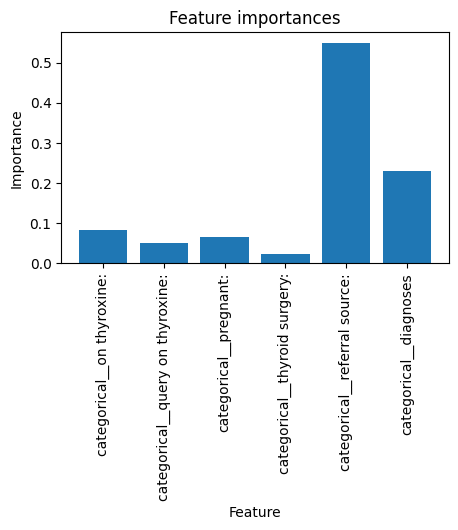

In [16]:
plot_importances(rf.feature_importances_, X_train_selected)

## Age Prediction

### Preprocess

In [17]:
import pandas as pd
import numpy as np

df_data = pd.read_csv("data/proj-data.csv")

X_train, y_train = data_cleaning_age(df_data)

cont_features = continuous_features.copy()
cont_features.remove('age:')

X_train_preprocessed = preprocess(categorical_features, cont_features, X_train)

### Feature Selection

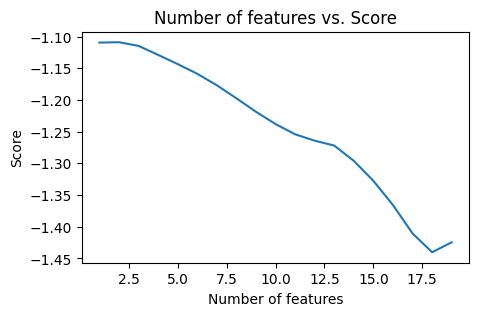

In [18]:
from sklearn.linear_model import LinearRegression
feature_scores = feature_selection(X_train_preprocessed, y_train, 20, LinearRegression())

In [19]:
X_train_selected = feature_scores[2][1]
print(f"Selected features: {X_train_selected.columns}")

Selected features: Index(['categorical__pregnant:', 'categorical__hypopituitary:'], dtype='object')


## Model Selection

In [20]:
from sklearn.tree import DecisionTreeRegressor;from sklearn.ensemble import RandomForestRegressor;from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR;from sklearn.linear_model import LinearRegression

regression_models = [DecisionTreeRegressor(),RandomForestRegressor(),KNeighborsRegressor(),SVR(),LinearRegression()]
model_scores = models_selection(X_train_selected, y_train, regression_models)

Cross validation score for model DecisionTreeRegressor() is -1.1089895837682484
Cross validation score for model RandomForestRegressor() is -1.0160802382734804
Cross validation score for model KNeighborsRegressor() is -0.07353986645467354
Cross validation score for model SVR() is -0.0046267759322911935
Cross validation score for model LinearRegression() is -1.1089895837682473


## Fine-tuning

In [21]:
svr_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}
svr = fine_tune_model(X_train_selected, y_train, SVR(), svr_params)

Best cross-validation score: -0.004428228451638127
Best estimator: SVR(C=1, degree=2, gamma='auto')



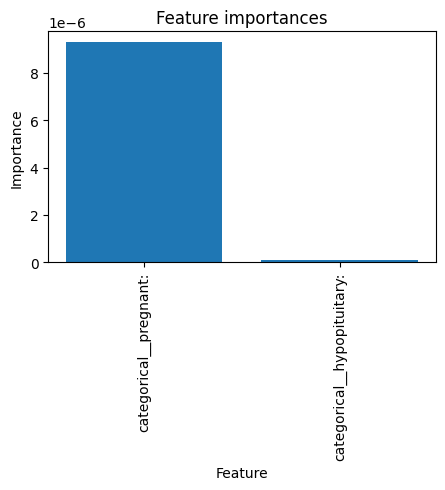

In [22]:
from sklearn.inspection import permutation_importance
importance = permutation_importance(svr, X_train_selected, y_train).importances_mean
plot_importances(importance, X_train_selected)

## Test

In [23]:
import pandas as pd;from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score;from sklearn.metrics import classification_report
from sklearn.svm import SVR;from sklearn.ensemble import RandomForestClassifier

df_data = pd.read_csv("data/proj-data.csv")

# Diagnoses prediction testing:
df_diag_test_data = pd.read_csv("data/proj-test-data.csv")
df_diag_class = pd.read_csv("data/proj-test-class.csv")

X_train, y_train = data_cleaning_diag(df_data)
X_test, y_test = data_cleaning_diag(df_diag_test_data, df_diag_class["diagnoses"])

cat_features = categorical_features.copy()
cat_features.remove('diagnoses')

X_train_pp, X_test_pp = preprocess(cat_features, continuous_features, X_train, X_test)

selected_feats = ['categorical__on thyroxine:', 'categorical__pregnant:',
       'categorical__thyroid surgery:', 'categorical__referral source:',
       'continuous__TSH:', 'continuous__T3:', 'continuous__TT4:',
       'continuous__FTI:', 'continuous__TBG:']
X_train_selected = X_train_pp[selected_feats]
X_test_selected = X_test_pp[selected_feats]

model_diagnose_pred = RandomForestClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=15,min_samples_split=5)
model_diagnose_pred.fit(X_train_pp, y_train)
diagnose_pred = model_diagnose_pred.predict(X_test_pp)
print("Diagnoses prediction results:")
print(classification_report(y_test, diagnose_pred, zero_division=0))
print()

# Age prediction testing:
df_age_test_data = pd.read_csv("data/test2-data.csv")
df_age_class = pd.read_csv("data/test2-age.csv")

X_train_pp, y_train = data_cleaning_age(df_data)
X_test_pp, y_test = data_cleaning_age(df_age_test_data, df_age_class["age:"])

cont_features = continuous_features.copy()
cont_features.remove('age:')

X_train_pp, X_test_pp = preprocess(categorical_features, cont_features, X_train_pp, X_test_pp)

selected_feats = ['categorical__pregnant:', 'categorical__hypopituitary:']
X_train_selected = X_train_pp[selected_feats]
X_test_selected = X_test_pp[selected_feats]

model_age_pred = SVR(C=1, degree=2, gamma='auto')
model_age_pred.fit(X_train_selected, y_train)
age_pred = model_age_pred.predict(X_test_selected)
print("Age prediction results:")
print(f"R2 score: {r2_score(y_test, age_pred)}")
print(f"Mean squared error: {mean_squared_error(y_test, age_pred)}")
print(f"Mean absolute error: {mean_absolute_error(y_test, age_pred)}")
print()

# Sex prediction testing:
df_sex_test_data = pd.read_csv("data/test3-data.csv")
df_sex_class = pd.read_csv("data/test3-sex.csv")

X_train_pp, y_train = data_cleaning_sex(df_data)
X_test_pp, y_test = data_cleaning_sex(df_sex_test_data, df_sex_class["sex:"])

cat_features = categorical_features.copy()
cat_features.remove('sex:')

X_train_pp, X_test_pp = preprocess(cat_features, continuous_features, X_train_pp, X_test_pp)

selected_feats = ['categorical__on thyroxine:', 'categorical__query on thyroxine:',
       'categorical__pregnant:', 'categorical__thyroid surgery:',
       'categorical__referral source:', 'categorical__diagnoses']
X_train_selected = X_train_pp[selected_feats]
X_test_selected = X_test_pp[selected_feats]

model_sex_pred = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,n_estimators=50)
model_sex_pred.fit(X_train_selected, y_train)
sex_pred = model_sex_pred.predict(X_test_selected)
print("Sex prediction results:")
print(classification_report(y_test, sex_pred, zero_division=0))

Diagnoses prediction results:
                         precision    recall  f1-score   support

         general health       0.00      0.00      0.00         1
                healthy       0.84      1.00      0.91        16
hyperthyroid conditions       0.00      0.00      0.00         1
 hypothyroid conditions       1.00      0.50      0.67         2

               accuracy                           0.85        20
              macro avg       0.46      0.38      0.40        20
           weighted avg       0.77      0.85      0.80        20


Age prediction results:
R2 score: -0.25149884287103785
Mean squared error: 338.69000309908176
Mean absolute error: 16.000000093911563

Sex prediction results:
              precision    recall  f1-score   support

           F       0.88      0.88      0.88        17
           M       0.33      0.33      0.33         3

    accuracy                           0.80        20
   macro avg       0.61      0.61      0.61        20
weighted avg   